<div style="background-color:#f5f5dc; padding:15px; border-radius:8px; font-size:16px; line-height:1.6;">

  <h3 style="margin-top:0;">Author: Nikolin Prenga</h3>

  <p><strong>Summary:</strong></p>

  <p>
    This notebook checks for consistency between image files and their corresponding YOLO annotation label files.
    It ensures that:
  </p>

  <ul>
    <li>Each image has a matching <code>.txt</code> label file</li>
    <li>Each label file corresponds to an existing image</li>
    <li>Optional cleanup or logging can be applied for mismatched files</li>
  </ul>

  <p>
    This is a crucial step before training object detection models to prevent training errors due to missing or mismatched files.
  </p>
</div>


In [30]:
import numpy as np
import cv2
import os   
import matplotlib.pyplot as plt
from PIL import Image
import shutil
import yaml
import random
from ultralytics import YOLO
import plotly.graph_objects as go

In [26]:
# This function counts the number of images per tumor type in a given folder 
# and visualizes the distribution using a bar plot.


def count_images_in_folder(folder_path, dataset_name):
    no_tumor =[]
    glioma = []
    meningioma = []
    pituitary = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            if '_gl_' in filename:
                glioma.append(filename)
            elif '_me_' in filename:
                meningioma.append(filename)
            elif '_pi_' in filename:
                pituitary.append(filename)
            elif '_no_' in filename:
                no_tumor.append(filename)
    print(f"Total images in {folder_path}: {len(os.listdir(folder_path))}")
    print(f"Total glioma images: {len(glioma)}")
    print(f"Total meningioma images: {len(meningioma)}")
    print(f"Total pituitary images: {len(pituitary)}")
    print(f"Total no_tumor images: {len(no_tumor)}")
    print(f"Total images with tumor: {len(glioma) + len(meningioma) + len(pituitary)+ len(no_tumor)}")

    name_tumor =['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
    number_of_images =[len(glioma), len(meningioma), len(no_tumor), len(pituitary)]
    colors = ['crimson', 'royalblue', 'seagreen', 'darkorange']


    fig = go.Figure(data=[go.Bar(
        x=name_tumor,
        y=number_of_images,
        marker_color=colors,
        width=[0.5] * 4 
    )])
    
    fig.update_layout(
        title={
            'text': f"Tumor Type Distribution in {dataset_name}",
            'x': 0.5,  # center title
            'xanchor': 'center',
            'font': dict(size=24)
        },
        xaxis_title="Tumor Type",
        yaxis_title="Number of Images",
        xaxis=dict(title_font=dict(size=18), tickfont=dict(size=15)),
        yaxis=dict(title_font=dict(size=18), tickfont=dict(size=15)),
        width=700,   # 50% of typical full width (≈1200)
        height=575,  # 15% taller than typical (≈500)
    )
    fig.show()


train_all_images = "Yolo_v11_Nikolin_Dataset/train/images"
test_all_images = "Yolo_v11_Nikolin_Dataset/test/images"
vals = 'Yolo_v11_Nikolin_Dataset/val/images'

count_images_in_folder(train_all_images, 'Training Dataset')
print('\n')
count_images_in_folder(test_all_images,  'Testing Dataset')



print('\n')
count_images_in_folder(vals, 'Validation Dataset')

Total images in Yolo_v11_Nikolin_Dataset/train/images: 4002
Total glioma images: 918
Total meningioma images: 1064
Total pituitary images: 1166
Total no_tumor images: 854
Total images with tumor: 4002




Total images in Yolo_v11_Nikolin_Dataset/test/images: 1000
Total glioma images: 254
Total meningioma images: 306
Total pituitary images: 300
Total no_tumor images: 140
Total images with tumor: 1000




Total images in Yolo_v11_Nikolin_Dataset/val/images: 998
Total glioma images: 229
Total meningioma images: 265
Total pituitary images: 291
Total no_tumor images: 213
Total images with tumor: 998


<div style="background-color:#f0f8ff; border:2px solid #000; padding:15px; font-size:16px; border-radius:5px;">
    <strong> Overlay mask on image to check if localization is correct</strong><br>

    From labels, Denormalize width, height, x_center, y_center to get box coordinates<br>

    Plot images with masks and boxes to visually confirm correctness<br>
    
    Helps detect potential annotation or bounding box errors
</div>


Total images with '_no_' in filename: 0


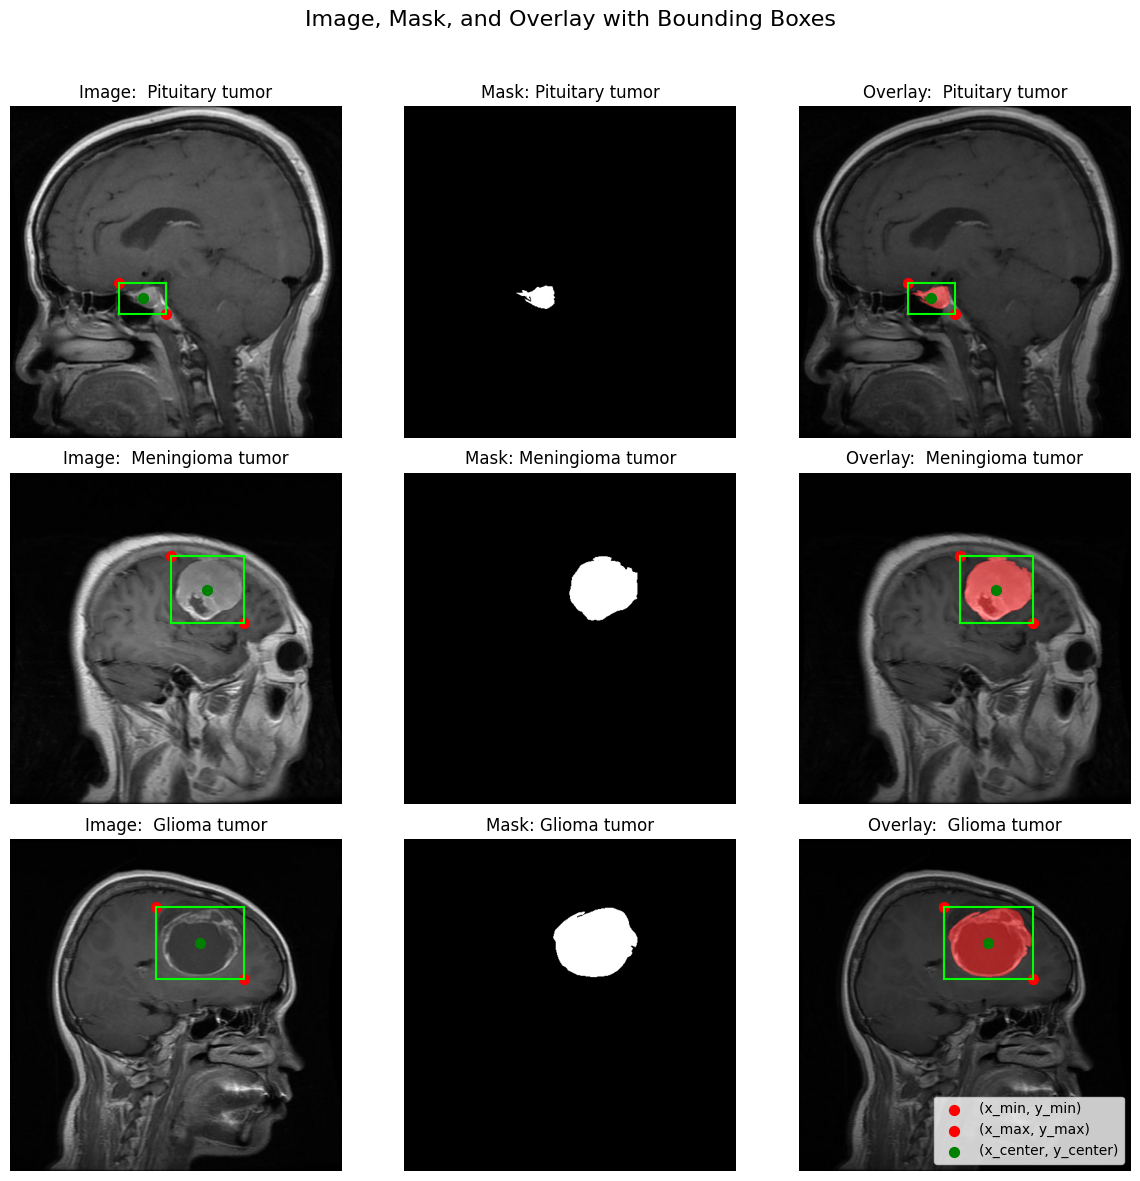

In [16]:
def denormalize_bboxes_and_plot(file_path, image_width, image_height, ax):

    with open(file_path, 'r') as files:
        for line in files:
            row = line.strip().split(' ')
            class_id = int(row[0])  # Class ID
            if class_id==1:
                class_name='Glioma  tumor'
            elif class_id==2:
                class_name='Meningioma tumor'
            elif class_id==3:
                class_name='Pituitary tumor'
            else:
                class_name='Unknown tumor'

            x_center_normalized = float(row[1])
            y_center_normalized = float(row[2])
            width_normalized = float(row[3])
            height_normalized = float(row[4])

            width = image_width * width_normalized
            height = image_height * height_normalized
            x_center = image_width * x_center_normalized
            y_center = image_height * y_center_normalized

            x_min = x_center - (width / 2)
            y_min = y_center - (height / 2)
            x_max = x_center + (width / 2)
            y_max = y_center + (height / 2) 

            # Draw on specific subplot
            ax.scatter(x_min, y_min, color='red', s=50, label='(x_min, y_min)')
            ax.scatter(x_max, y_max, color='red',   s=50,   label='(x_max, y_max)')
            ax.scatter(x_center, y_center, color='green', s=50, label='(x_center, y_center)')

            ax.plot([x_min, x_max], [y_min, y_min], color='lime')       
            ax.plot([x_min, x_min], [y_min, y_max], color='lime')
            ax.plot([x_max, x_max], [y_min, y_max], color='lime')
            ax.plot([x_min, x_max], [y_max, y_max], color='lime')
            ax.set_title(f"Class: {class_name} (ID: {class_id})"   )


def _check_labels_in_images(image_path, mask_path, label_path, to_start):
    to_count = 0
    count_no_tumor = 0

    images_to_plot = []
    masks_to_plot = []
    labels_to_use = []

    image_files = os.listdir(image_path)[to_start:]

    for file in image_files:
        if '_no_' in file:
            label_file = file.replace('.jpg', '.txt').replace('.png', '.txt')
            full_path_label = os.path.join(label_path, label_file)

            if os.path.isfile(full_path_label):
                with open(full_path_label, 'r') as no_tumor:
                    line = no_tumor.read().strip()
                    print(f"Label for {file}: {line}")
                    count_no_tumor += 1
            else:
                print(f"Label file not found for {file}. Skipping.")
            continue

        img_path = os.path.join(image_path, file)
        mask_path_full = os.path.join(mask_path, file)
        label_path_full = os.path.join(label_path, file.replace('.jpg', '.txt').replace('.png', '.txt'))

        images_to_plot.append(img_path)
        masks_to_plot.append(mask_path_full)
        labels_to_use.append(label_path_full)

        to_count += 1
        if to_count >= 3:
            break

    print(f"Total images with '_no_' in filename: {count_no_tumor}")

    # Plotting
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))
    for i in range(3):
        # Read image and mask
        image = cv2.imread(images_to_plot[i])
        if '_gl_' in images_to_plot[i]:
            class_name = 'Glioma tumor'
        elif '_me_' in images_to_plot[i]:
            class_name = 'Meningioma tumor'
        elif '_pi_' in images_to_plot[i]:
            class_name = 'Pituitary tumor'
        else:
            class_name = 'Unknown tumor'

        image_width, image_height = image.shape[1], image.shape[0]
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(masks_to_plot[i], cv2.IMREAD_GRAYSCALE)



        mask_color = np.zeros_like(image)
        mask_color[:, :, 0] = mask     # Red channel (RGB)
        mask_color[:, :, 1] = 0        # Green
        mask_color[:, :, 2] = 0        # Blue

        overlay = cv2.addWeighted(image, 0.7, mask_color, 0.5, 0)





        axs[i][0].imshow(image)
        denormalize_bboxes_and_plot(labels_to_use[i], image_width, image_height, axs[i][0])
        axs[i][0].set_title(f"Image:  {class_name}")
        axs[i][1].imshow(mask, cmap='gray')
        axs[i][1].set_title(f"Mask: {class_name}")
        axs[i][2].imshow(overlay)
        denormalize_bboxes_and_plot(labels_to_use[i], image_width, image_height, axs[i][2])
        axs[i][2].set_title(f"Overlay:  {class_name}")

        for j in range(3):
            axs[i][j].axis('off')

    plt.tight_layout()
    plt.legend(loc='lower right')
    plt.subplots_adjust(top=0.9)
    plt.suptitle('Image, Mask, and Overlay with Bounding Boxes', fontsize=16)
    plt.show()


image_path= 'Yolo_v11_Nikolin_Dataset/test/images'
mask_path = 'Yolo_v11_Nikolin_Dataset/test/masks'
label_path = 'Yolo_v11_Nikolin_Dataset/test/labels'
_check_labels_in_images(image_path, mask_path, label_path, to_start=333)


<div style="background-color:#fff8dc; border:2px solid #000; padding:15px; font-size:18px; border-radius:5px; line-height:1.6;">
    Here we want to check whether the <code>get_skull_bbox</code> function produces correct coordinates for <code>x_min</code>, <code>y_min</code>, <code>width</code>, and <code>height</code>.  
    Then we create a Python function, <code>draw_skull_bbox</code>, that plots the boxes around the skull.  
    This allows us to evaluate whether <code>get_skull_bbox</code> works properly.
</div>


In [17]:

def get_skull_bbox(image_path):
    """
    Returns the bounding box (x_min, y_min, width, height) around the skull in an MRI image.

    Args:
        image_path (str): Path to the input image.

    Returns:
        tuple: (x_min, y_min, width, height)
    """
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    _, thresh = cv2.threshold(gray, 80, 255, cv2.THRESH_BINARY)
    kernel = np.ones((5, 5), np.uint8)
    cleaned = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return None  # No contour found

    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    return x, y, w, h





def draw_skull_bbox(image, bbox):
    x_min, y_min, width, height = bbox
    x_max = x_min + width
    y_max = y_min + height

    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2 

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.scatter(x_min, y_min, color='red', s=50, label='(x_min, y_min)')
    plt.scatter(x_max, y_max, color='red', s=50, label='(x_max, y_max)')
    plt.scatter(x_center, y_center, color='green', s=50, label='(x_center, y_center)')
    plt.plot([x_min, x_max], [y_min, y_min], color='lime')       
    plt.plot([x_min, x_min], [y_min, y_max], color='lime')
    plt.plot([x_max, x_max], [y_min, y_max], color='lime')
    plt.plot([x_min, x_max], [y_max, y_max], color='lime')
    plt.title("Bounding Box around Skull")
    plt.legend()
    plt.axis('off')
    plt.show()


# images = os.listdir('Yolo_v11_Nikolin_Dataset/test/images')

# images = [img for img in images if  '_no_' in img]



# for image in images:
#     image_path =os.path.join('Yolo_v11_Nikolin_Dataset/test/images', image)
#     print(f"Processing image: {image_path}")
#     image = cv2.imread(image_path)
#     bbox = get_skull_bbox(image_path)
#     if bbox:
#         draw_skull_bbox(image, bbox)
#     else:
#         print(f"No skull bounding box found for {image_path}")


In [19]:
def mask_to_bboxes(mask, min_area=180):
    # Step 1: Ensure single-channel binary mask (0 and 255, uint8)
    if mask.ndim == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    mask_bin = (mask > 0).astype(np.uint8)

    # Step 2: Find contours
    #contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours, _ = cv2.findContours(mask_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


    # Step 3: Extract and filter bounding boxes
    bboxes = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w * h >= min_area:  # ignore tiny noise
            bboxes.append((x, y, w, h))
    return bboxes

Lnegth of image paths: 3
Image path: Data_organize_Nikolin/test/images/_00772_pi_ax_t1.jpg   
mask path: Data_organize_Nikolin/test/masks/_00772_pi_ax_t1.jpg   
Image path: Data_organize_Nikolin/test/images/_00855_pi_co_t1.jpg   
mask path: Data_organize_Nikolin/test/masks/_00855_pi_co_t1.jpg   
Image path: Data_organize_Nikolin/test/images/_00119_gl_co_t1.jpg   
mask path: Data_organize_Nikolin/test/masks/_00119_gl_co_t1.jpg   


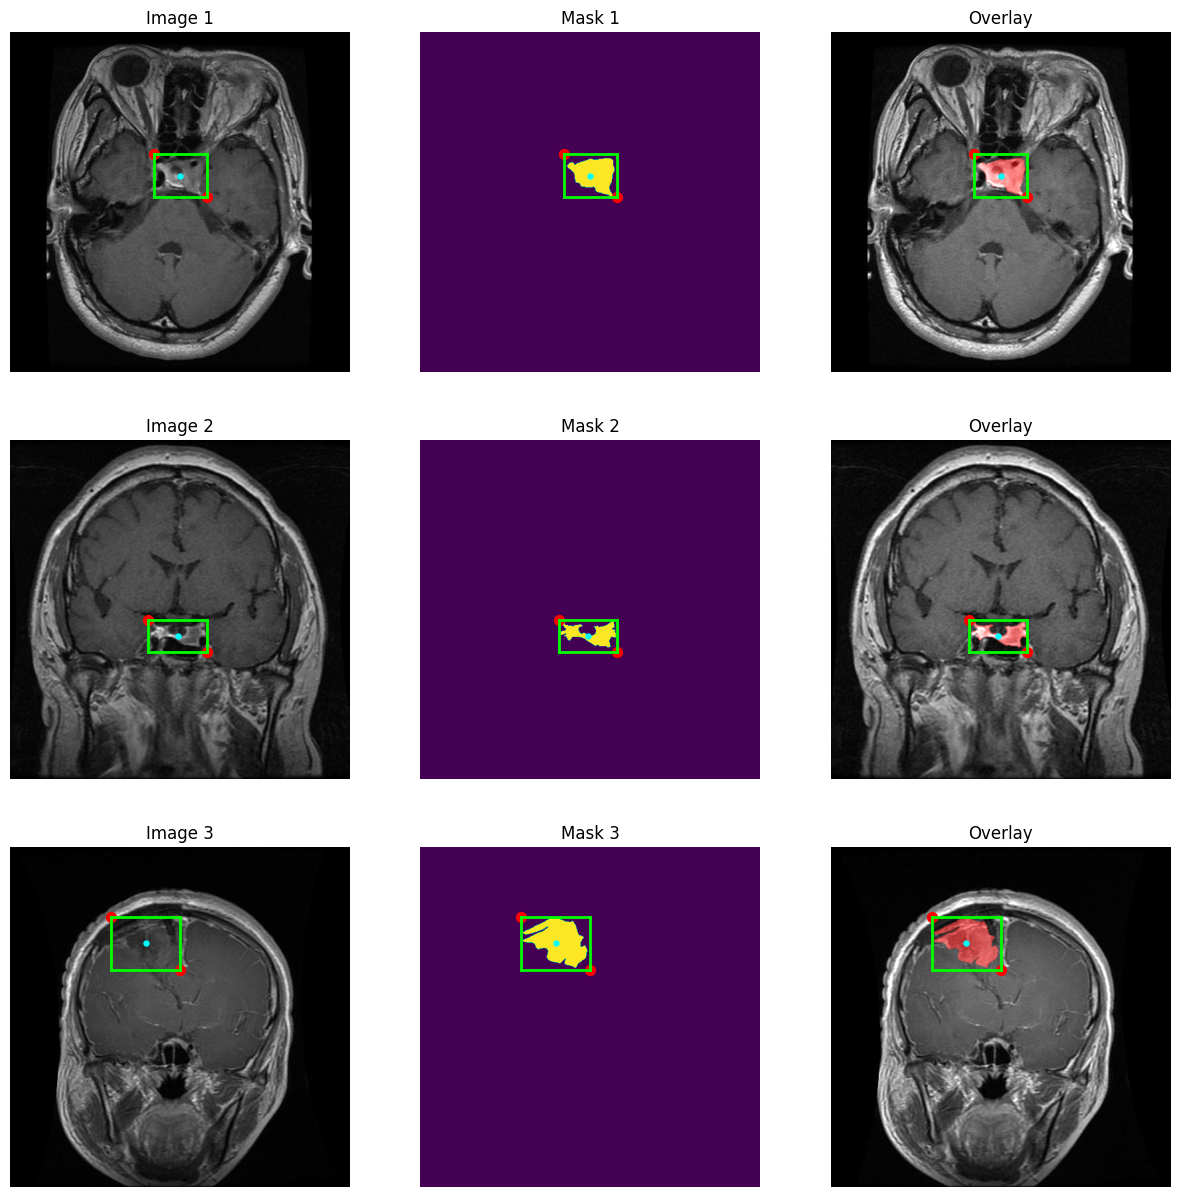

In [31]:
def draw_bboxes(image, bboxes):
    for (x_min, y_min, width, height) in bboxes:
        x_max = x_min + width
        y_max = y_min + height
        x_center = x_min + width / 2
        y_center = y_min + height / 2

        plt.scatter(x_center, y_center, color='cyan', marker='.', s=50)
        plt.scatter(x_min, y_min, color='red', marker='o', s=50)
        plt.scatter(x_max, y_max, color='red', marker='o', s=50)

        plt.plot([x_min, x_max], [y_min, y_min], color='lime', linewidth=2) # Bottom edge
        plt.plot([x_min, x_max], [y_max, y_max], color='lime', linewidth=2) # Left edge
        plt.plot([x_min, x_min], [y_min, y_max], color='lime', linewidth=2) # Right edge
        plt.plot([x_max, x_max], [y_min, y_max], color='lime', linewidth=2) # Right edge




def check_bboxes_in_image(image_path, mask_path,  make_boxes, start):
    """
    Check if bounding boxes are present in the image and mask.
    """
    #make a list of all images in the image_path and mask paths
    all_images = os.listdir(image_path)[start: ]
    image_paths =[]

    to_stop = 0

    for ims_paths in all_images:

        if   '_no_' in ims_paths:
            continue
        image_paths.append(ims_paths)
        to_stop += 1
        if to_stop ==3:
            break


    mask_paths= os.listdir(mask_path)
    print(f'Lnegth of image paths: {len(image_paths)}')

    # make a list of all images and its corresponding boundary boxes via the given function
    images = []
    masks = []
    bboxes = []

    for image_name in image_paths:

        im_path = os.path.join(image_path, image_name)
        image = cv2.imread(im_path, cv2.IMREAD_COLOR)

        mask_file_path = os.path.join(mask_path, image_name)
        mask = cv2.imread(mask_file_path, cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            print(f"Image or mask is None for {image_name}")
            continue    
        
        # Get bounding boxes from the mask
        bbox = make_boxes(mask)
        print(f'Image path: {im_path}   ')
        print(f'mask path: {mask_file_path}   ')

        bboxes.append(bbox)
        images.append(image)
        masks.append(mask)

    # print(f'Number of images: {len(images)}')
    # print(f'Number of masks: {len(masks)}')
    # print(f'Number of bounding boxes: {len(bboxes)}')

    
    plt.figure(figsize=(15, 15))
    plt.subplot(3, 3, 1)
    plt.imshow(images[0])
    plt.title('Image 1')
    plt.axis('off')
    draw_bboxes(images[0], bboxes[0] )

        


    # Display the first mask
    plt.subplot(3, 3, 2)
    mask1 = cv2.resize(masks[0], (images[0].shape[1], images[0].shape[0])) 
    plt.imshow(mask1)
    plt.title('Mask 1')
    plt.axis('off')
    draw_bboxes(mask1, bboxes[0] )

    #make an overlay of the mask on the image
    plt.subplot(3, 3, 3)
    mask_color = np.zeros_like(images[0] )
    mask_color[: , : , 0] = mask1  # Red color for the mask
    overlay = cv2.addWeighted(images[0], 1.3, mask_color, 0.5, 0)
    plt.imshow(overlay)
    plt.title('Overlay')
    plt.axis('off')
    draw_bboxes(overlay, bboxes[0] )

    # Display the second image
    plt.subplot(3, 3, 4)
    plt.imshow(images[1])
    plt.title('Image 2')
    plt.axis('off')
    draw_bboxes(images[1], bboxes[1] )



    # Display the second mask
    plt.subplot(3, 3, 5)
    mask2 = cv2.resize(masks[1], (images[1].shape[1], images[1].shape[0])) 
    plt.imshow(mask2)
    plt.title('Mask 2')
    plt.axis('off') 
    draw_bboxes(mask2, bboxes[1] )



    #make an overlay of the mask on the second  image    

    plt.subplot(3, 3, 6)
    mask_color = np.zeros_like(images[2] )
    mask_color[: , : , 0] = mask2  # Red color for the mask
    overlay = cv2.addWeighted(images[1], 1.3, mask_color, 0.5, 0)
    plt.imshow(overlay)
    plt.title('Overlay')
    plt.axis('off')
    draw_bboxes(overlay, bboxes[1] )

    plt.subplot(3, 3, 7)
    plt.imshow(images[2])
    plt.title('Image 3')
    plt.axis('off')
    draw_bboxes(images[2], bboxes[2] )

    # Display the third mask
    plt.subplot(3, 3, 8)
    mask3 = cv2.resize(masks[2], (images[2].shape[1], images[2].shape[0])) 
    plt.imshow(mask3)
    plt.title('Mask 3')
    plt.axis('off') 
    draw_bboxes(mask3, bboxes[2] )

    #make an overlay of the mask on the third image
    plt.subplot(3, 3, 9)
    mask_color = np.zeros_like(images[2] )
    mask_color[: , : , 0] = mask3  # Red color for the mask
    overlay = cv2.addWeighted(images[2], 1.3, mask_color, 0.5, 0)
    plt.imshow(overlay)
    plt.title('Overlay')
    plt.axis('off')
    draw_bboxes(overlay, bboxes[2])

    plt.show()

image_path = 'Data_organize_Nikolin/test/images'
mask_path = 'Data_organize_Nikolin/test/masks'
check_bboxes_in_image(image_path, mask_path,  mask_to_bboxes, 666)


<div style="background-color:#e6f7ff; border:2px solid #000; padding:10px; font-size:18px; border-radius:5px;">
    Demonstrate bounding boxes
</div>


Bounding Box: x_min=294, y_min=41, width=232, height=400
 Image shape: (481, 820, 3)


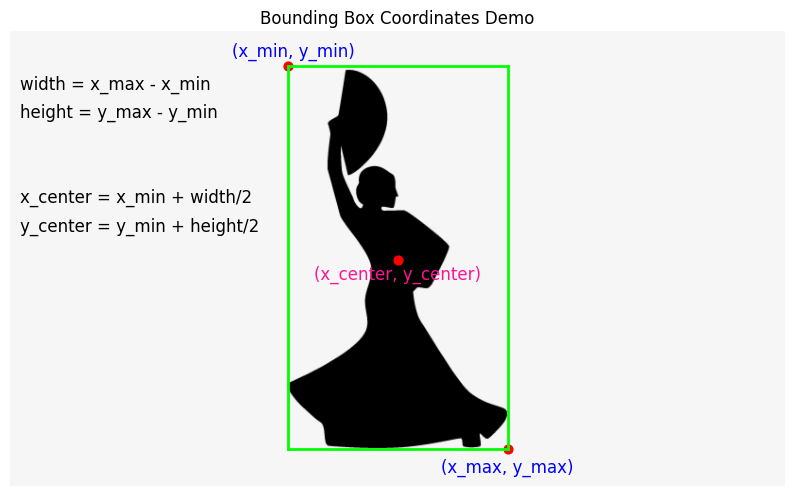

In [32]:
Image_demons =cv2.imread('somethin1.png')


bbox = mask_to_bboxes(Image_demons, min_area=1000)

x_min=bbox[1][0]
y_min=bbox[1][1]
width=bbox[1][2]
height=bbox[1][3]  

print(f"Bounding Box: x_min={bbox[1][0]}, y_min={bbox[1][1]}, width={bbox[1][2]}, height={bbox[1][3]  }")
print(f' Image shape: {Image_demons.shape}')

plt.figure(figsize=(10, 10))
plt.imshow(Image_demons)
plt.scatter(x_min,y_min-5, color='red', s=40)
plt.text(x_min+70, y_min-16, '(x_min, y_min)', color='blue', fontsize=12, ha='right')

plt.scatter(x_min + width, y_min + height, color='red', s=40)
plt.text(x_min+ width-70, y_min+height+25, '(x_max, y_max)', color='blue', fontsize=12)

plt.plot([x_min, x_min + width],[y_min-5, y_min-5], color='lime', linewidth=2)
plt.plot([x_min + width, x_min + width],[y_min-5, y_min + height], color='lime', linewidth=2)
plt.plot([x_min + width, x_min],[y_min + height, y_min + height], color='lime', linewidth=2)
plt.plot([x_min, x_min],[y_min + height, y_min-5], color='lime', linewidth=2)
plt.scatter(x_min + width/2, y_min + height/2, color='red', s=40)
plt.text(x_min + width/2, y_min + height/2 + 20, '(x_center, y_center)', color='deeppink', fontsize=12, ha='center')

plt.text(10, 60, 'width = x_max - x_min', color='black', fontsize=12)
plt.text(10, 90, 'height = y_max - y_min', color='black', fontsize=12)
plt.text(10, 180, 'x_center = x_min + width/2', color='black', fontsize=12)
plt.text(10, 210, 'y_center = y_min + height/2', color='black', fontsize=12)
plt.axis('off')
plt.title("Bounding Box Coordinates Demo")


plt.show()

<div style="background-color:#e6f7ff; border:2px solid #000; padding:10px; font-size:18px; border-radius:5px;">
    Demonstrate bounding boxes
</div>



Glioma Axial: 394
Glioma Coronal: 430
Glioma Sagittal: 323


Meningioma Axial: 423
Meningioma Coronal: 426
Meningioma Sagittal: 480


Pituitary Axial: 426
Pituitary Coronal: 510
Pituitary Sagittal: 521


No Tumor Axial: 352
No Tumor Coronal: 310
No Tumor Sagittal: 405




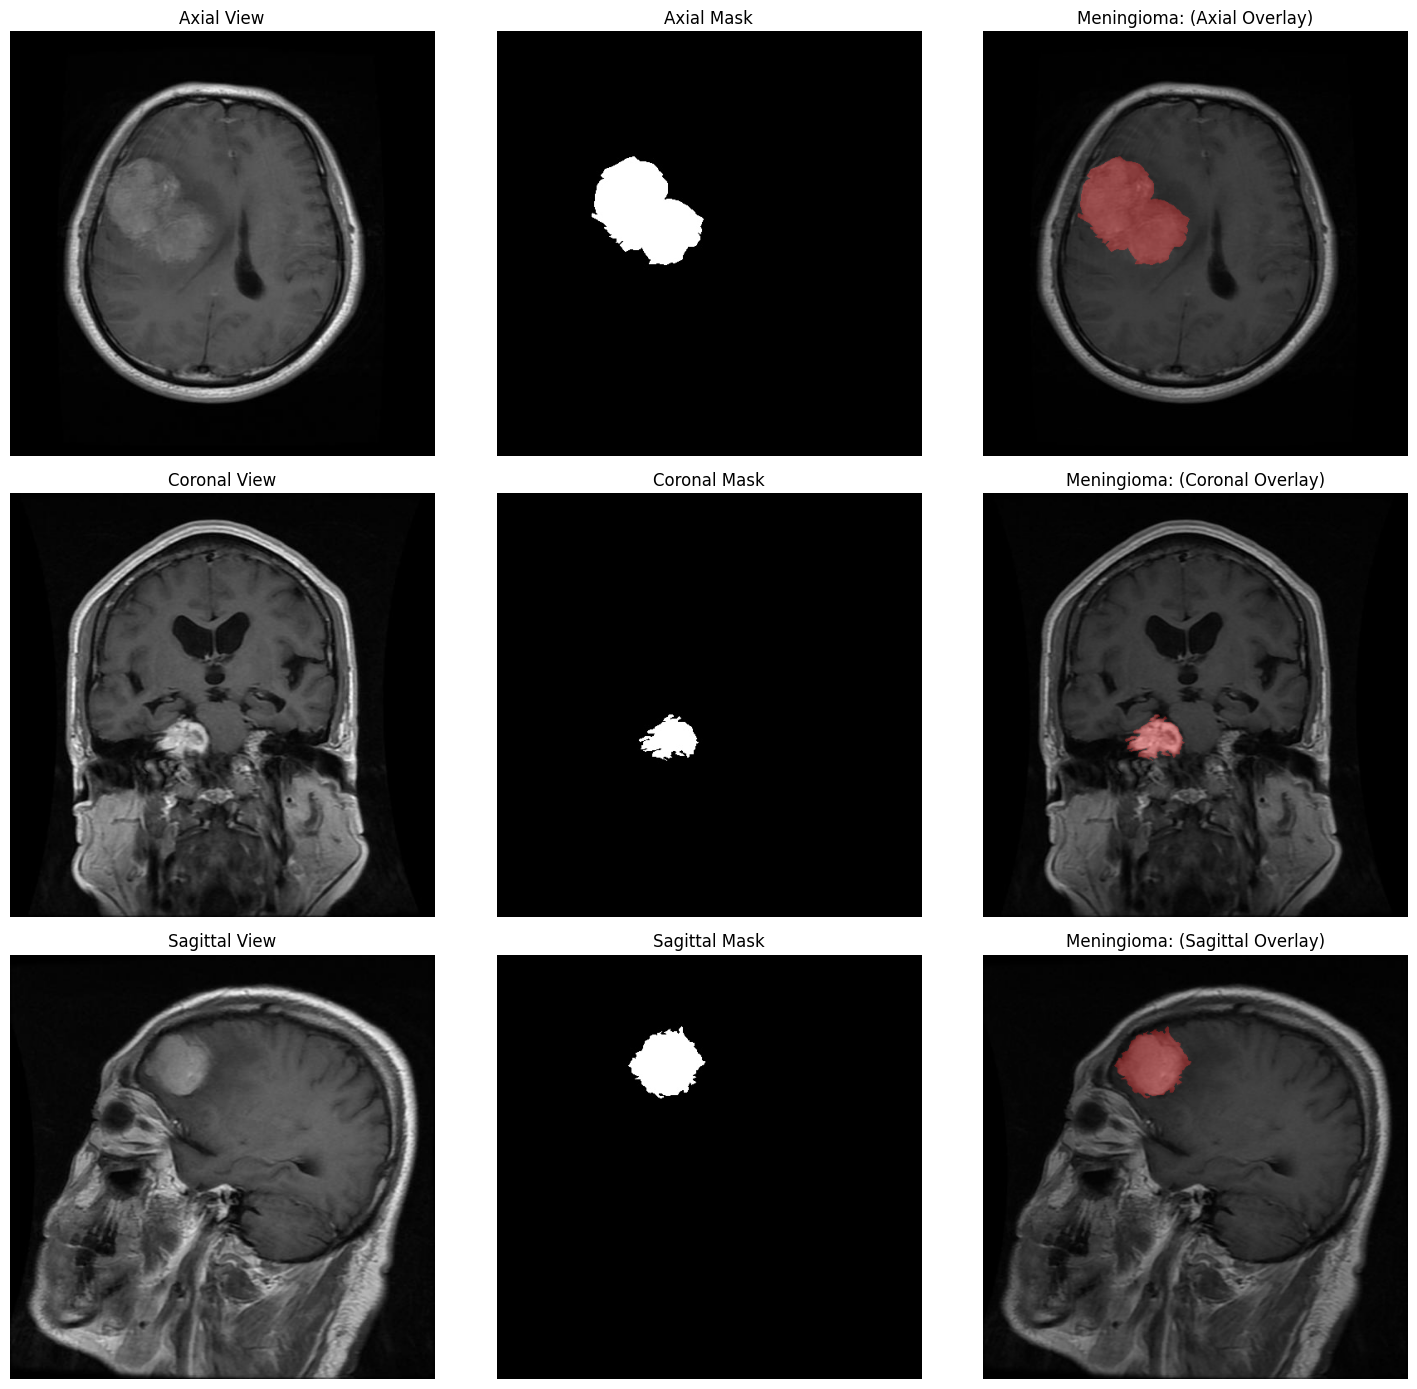

In [ ]:
def count_images_in_folder(folder_path_image, folder_path_mask, Title):

    glioma_axial =[]
    glioma_coronal = []
    glioma_sagittal = []

    meningioma_axial = []
    meningioma_coronal = []
    meningioma_sagittal = []

    pituitary_axial = []
    pituitary_coronal = []
    pituitary_sagittal = []


    no_tumor_axial = []
    no_tumor_coronal = []
    no_tumor_sagittal = []  

    for filename in os.listdir(folder_path_image):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            full_path = os.path.join(folder_path_image, filename)
            if '_gl_ax_' in filename:
                glioma_axial.append(full_path)
            elif '_gl_co_' in filename:
                glioma_coronal.append(full_path)
            elif '_gl_sa_' in filename:
                glioma_sagittal.append(full_path)
            
            elif '_me_ax_' in filename:
                meningioma_axial.append(full_path)
            elif '_me_co_' in filename:
                meningioma_coronal.append(full_path)
            elif '_me_sa_' in filename:
                meningioma_sagittal.append(full_path)


            elif '_pi_ax_' in filename:
                pituitary_axial.append(full_path)
            elif '_pi_co_' in filename:
                pituitary_coronal.append(full_path)
            elif '_pi_sa_' in filename:
                pituitary_sagittal.append(full_path)

            elif '_no_ax_' in filename:
                no_tumor_axial.append(full_path)
            elif '_no_co_' in filename:
                no_tumor_coronal.append(full_path)
            elif '_no_sa_' in filename:
                no_tumor_sagittal.append(full_path)
    print(f'Glioma Axial: {len(glioma_axial)}')
    print(f'Glioma Coronal: {len(glioma_coronal)}')
    print(f'Glioma Sagittal: {len(glioma_sagittal)}')
    print('\n')
    print(f'Meningioma Axial: {len(meningioma_axial)}')
    print(f'Meningioma Coronal: {len(meningioma_coronal)}')
    print(f'Meningioma Sagittal: {len(meningioma_sagittal)}')
    print('\n')
    print(f'Pituitary Axial: {len(pituitary_axial)}')
    print(f'Pituitary Coronal: {len(pituitary_coronal)}')
    print(f'Pituitary Sagittal: {len(pituitary_sagittal)}')
    print('\n')
    print(f'No Tumor Axial: {len(no_tumor_axial)}')
    print(f'No Tumor Coronal: {len(no_tumor_coronal)}')
    print(f'No Tumor Sagittal: {len(no_tumor_sagittal)}')

    print('\n' )

    if Title =='Glioma':
        axial_list = glioma_axial
        coronal_list = glioma_coronal
        saggital_list = glioma_sagittal
    elif Title == 'Meningioma':
        axial_list = meningioma_axial
        coronal_list = meningioma_coronal
        saggital_list = meningioma_sagittal
    elif Title == 'Pituitary':
        axial_list = pituitary_axial
        coronal_list = pituitary_coronal
        saggital_list = pituitary_sagittal
    elif Title == 'No Tumor':
        axial_list = no_tumor_axial
        coronal_list = no_tumor_coronal
        saggital_list = no_tumor_sagittal
    else:
        raise ValueError("Invalid Title. Choose from 'Glioma', 'Meningioma', 'Pituitary', or 'No Tumor'.")
    

    plot_images_in_planes(axial_list, coronal_list, saggital_list, folder_path_mask, Title)
    



def plot_images_in_planes(axial_list, coronal_list, saggital_list, mask_paths, Title):

    index_axial = int(random.randint(1, 50))
    index_coronal = int(random.randint(1, 50))
    index_sagittal = int(random.randint(0, 50))

    # Axial
    image_axial = cv2.imread(axial_list[index_axial])
    mask_path_axial = os.path.join(mask_paths, os.path.basename(axial_list[index_axial]))
    mask_axial = cv2.imread(mask_path_axial, cv2.IMREAD_GRAYSCALE)

    mask_color_axial = np.zeros_like(image_axial)
    mask_color_axial[:, :, 2] = mask_axial
    overlay_axial = cv2.addWeighted(image_axial, 0.7, mask_color_axial, 0.3, 0)

    # Coronal
    image_coronal = cv2.imread(coronal_list[index_coronal])
    mask_path_coronal = os.path.join(mask_paths, os.path.basename(coronal_list[index_coronal]))
    mask_coronal = cv2.imread(mask_path_coronal, cv2.IMREAD_GRAYSCALE)

    mask_color_coronal = np.zeros_like(image_coronal)
    mask_color_coronal[:, :, 2] = mask_coronal  
    overlay_coronal = cv2.addWeighted(image_coronal, 0.7, mask_color_coronal, 0.3, 0)

    # Sagittal
    image_sagittal = cv2.imread(saggital_list[index_sagittal])
    mask_path_sagittal = os.path.join(mask_paths, os.path.basename(saggital_list[index_sagittal]))
    mask_sagittal = cv2.imread(mask_path_sagittal, cv2.IMREAD_GRAYSCALE)

    mask_color_sagittal = np.zeros_like(image_sagittal)
    mask_color_sagittal[:, :, 2] = mask_sagittal
    overlay_sagittal = cv2.addWeighted(image_sagittal, 0.7, mask_color_sagittal, 0.3, 0)

    # Plotting
    plt.figure(figsize=(15, 14))

    plt.subplot(3, 3, 1)
    plt.imshow(cv2.cvtColor(image_axial, cv2.COLOR_BGR2RGB))
    plt.title(f'Axial View')
    plt.axis('off')

    plt.subplot(3, 3, 2)
    plt.imshow(mask_axial, cmap='gray')
    plt.title('Axial Mask')
    plt.axis('off')

    plt.subplot(3, 3, 3)
    plt.imshow(cv2.cvtColor(overlay_axial, cv2.COLOR_BGR2RGB))
    plt.title(f'{Title}: (Axial Overlay)')
    plt.axis('off')

    plt.subplot(3, 3, 4)
    plt.imshow(cv2.cvtColor(image_coronal, cv2.COLOR_BGR2RGB))
    plt.title(f'Coronal View')
    plt.axis('off')     

    plt.subplot(3, 3, 5)
    plt.imshow(mask_coronal, cmap='gray')
    plt.title('Coronal Mask')
    plt.axis('off')     

    plt.subplot(3, 3, 6)
    plt.imshow(cv2.cvtColor(overlay_coronal, cv2.COLOR_BGR2RGB))
    plt.title(f'{Title}: (Coronal Overlay)')
    plt.axis('off') 

    plt.subplot(3, 3, 7)
    plt.imshow(cv2.cvtColor(image_sagittal, cv2.COLOR_BGR2RGB))
    plt.title(f'Sagittal View')
    plt.axis('off')     

    plt.subplot(3, 3, 8)
    plt.imshow(mask_sagittal, cmap='gray')
    plt.title('Sagittal Mask')
    plt.axis('off') 

    plt.subplot(3, 3, 9)
    plt.imshow(cv2.cvtColor(overlay_sagittal, cv2.COLOR_BGR2RGB))
    plt.title(f'{Title}: (Sagittal Overlay)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()










folder_path ='Data_organize_Nikolin/train/images'


folder_path_mask = 'Data_organize_Nikolin/train/masks'

count_images_in_folder(folder_path,folder_path_mask,  'Meningioma')



<div style="background-color:#e6f7ff; border:2px solid #000; padding:10px; font-size:18px; border-radius:5px;">
    Showing True Labels from Masks and How the Bounding Boxes Look
</div>

Lnegth of image paths: 3
Image path: Data_organize_Nikolin/test/images/_00772_pi_ax_t1.jpg   
mask path: Data_organize_Nikolin/test/masks/_00772_pi_ax_t1.jpg   
Image path: Data_organize_Nikolin/test/images/_00855_pi_co_t1.jpg   
mask path: Data_organize_Nikolin/test/masks/_00855_pi_co_t1.jpg   
Image path: Data_organize_Nikolin/test/images/_00119_gl_co_t1.jpg   
mask path: Data_organize_Nikolin/test/masks/_00119_gl_co_t1.jpg   


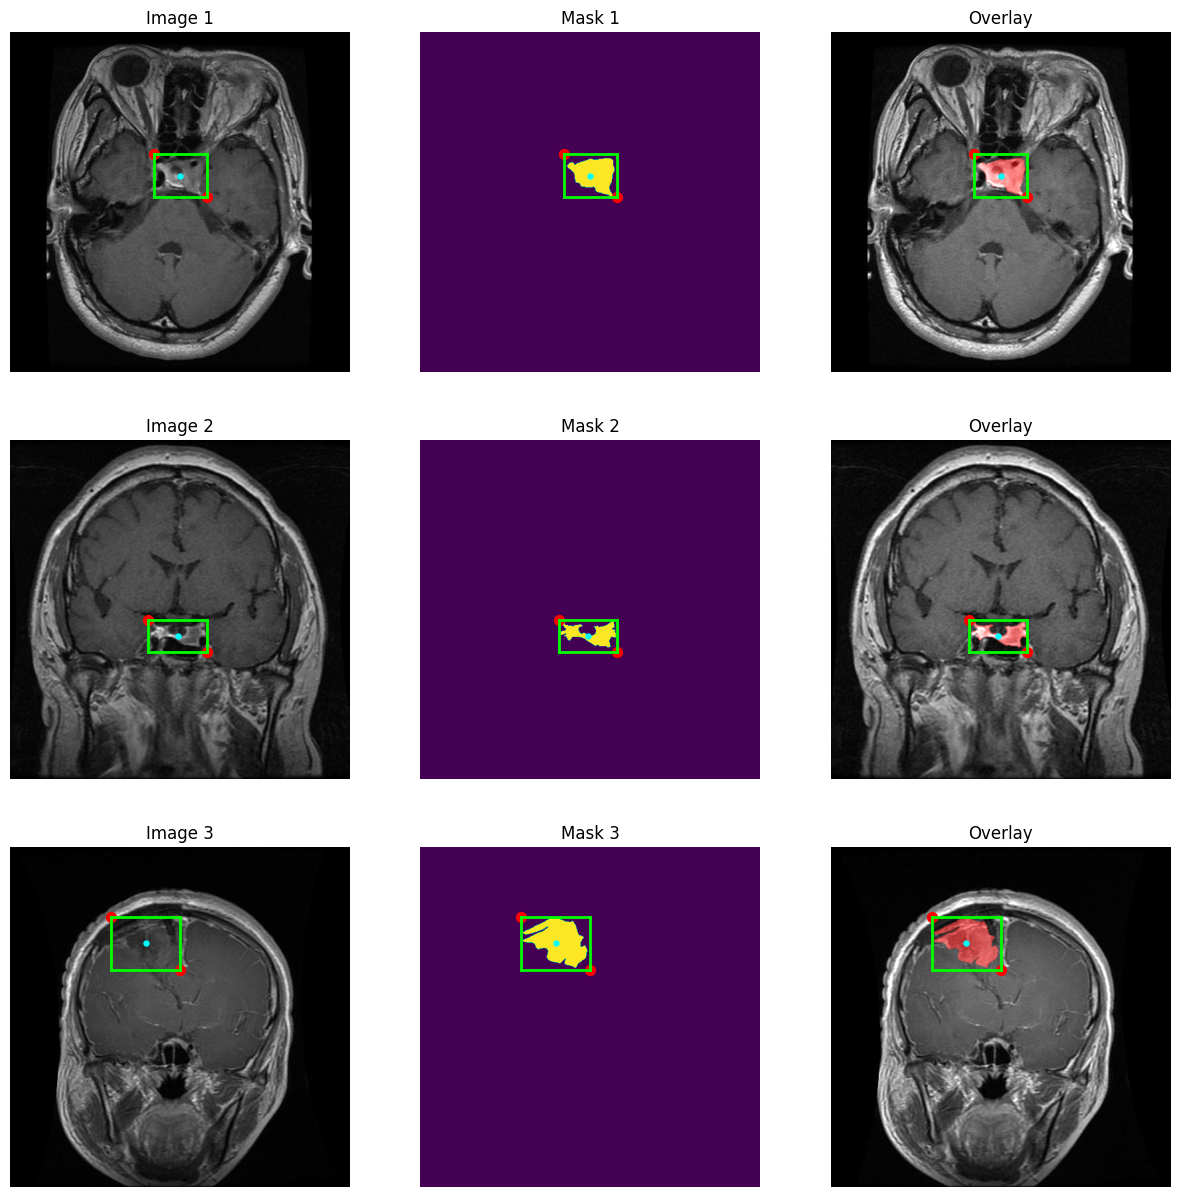

In [ ]:
def draw_bboxes(image, bboxes):
    for (x_min, y_min, width, height) in bboxes:
        x_max = x_min + width
        y_max = y_min + height
        x_center = x_min + width / 2
        y_center = y_min + height / 2

        plt.scatter(x_center, y_center, color='cyan', marker='.', s=50)
        plt.scatter(x_min, y_min, color='red', marker='o', s=50)
        plt.scatter(x_max, y_max, color='red', marker='o', s=50)

        plt.plot([x_min, x_max], [y_min, y_min], color='lime', linewidth=2) # Bottom edge
        plt.plot([x_min, x_max], [y_max, y_max], color='lime', linewidth=2) # Left edge
        plt.plot([x_min, x_min], [y_min, y_max], color='lime', linewidth=2) # Right edge
        plt.plot([x_max, x_max], [y_min, y_max], color='lime', linewidth=2) # Right edge



def check_bboxes_in_image(image_path, mask_path,  make_boxes, start):
    """
    Check if bounding boxes are present in the image and mask.
    """
    #make a list of all images in the image_path and mask paths
    all_images = os.listdir(image_path)[start: ]
    image_paths =[]

    to_stop = 0

    for ims_paths in all_images:

        if   '_no_' in ims_paths:
            continue
        image_paths.append(ims_paths)
        to_stop += 1
        if to_stop ==3:
            break


    mask_paths= os.listdir(mask_path)
    print(f'Lnegth of image paths: {len(image_paths)}')

    # make a list of all images and its corresponding boundary boxes via the given function
    images = []
    masks = []
    bboxes = []

    for image_name in image_paths:

        im_path = os.path.join(image_path, image_name)
        image = cv2.imread(im_path, cv2.IMREAD_COLOR)

        mask_file_path = os.path.join(mask_path, image_name)
        mask = cv2.imread(mask_file_path, cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            print(f"Image or mask is None for {image_name}")
            continue    
        
        # Get bounding boxes from the mask
        bbox = make_boxes(mask)
        print(f'Image path: {im_path}   ')
        print(f'mask path: {mask_file_path}   ')

        bboxes.append(bbox)
        images.append(image)
        masks.append(mask)

    # print(f'Number of images: {len(images)}')
    # print(f'Number of masks: {len(masks)}')
    # print(f'Number of bounding boxes: {len(bboxes)}')

    
    plt.figure(figsize=(15, 15))
    plt.subplot(3, 3, 1)
    plt.imshow(images[0])
    plt.title('Image 1')
    plt.axis('off')
    draw_bboxes(images[0], bboxes[0] )

        


    # Display the first mask
    plt.subplot(3, 3, 2)
    mask1 = cv2.resize(masks[0], (images[0].shape[1], images[0].shape[0])) 
    plt.imshow(mask1)
    plt.title('Mask 1')
    plt.axis('off')
    draw_bboxes(mask1, bboxes[0] )

    #make an overlay of the mask on the image
    plt.subplot(3, 3, 3)
    mask_color = np.zeros_like(images[0] )
    mask_color[: , : , 0] = mask1  # Red color for the mask
    overlay = cv2.addWeighted(images[0], 1.3, mask_color, 0.5, 0)
    plt.imshow(overlay)
    plt.title('Overlay')
    plt.axis('off')
    draw_bboxes(overlay, bboxes[0] )

    # Display the second image
    plt.subplot(3, 3, 4)
    plt.imshow(images[1])
    plt.title('Image 2')
    plt.axis('off')
    draw_bboxes(images[1], bboxes[1] )



    # Display the second mask
    plt.subplot(3, 3, 5)
    mask2 = cv2.resize(masks[1], (images[1].shape[1], images[1].shape[0])) 
    plt.imshow(mask2)
    plt.title('Mask 2')
    plt.axis('off') 
    draw_bboxes(mask2, bboxes[1] )



    #make an overlay of the mask on the second  image    

    plt.subplot(3, 3, 6)
    mask_color = np.zeros_like(images[2] )
    mask_color[: , : , 0] = mask2  # Red color for the mask
    overlay = cv2.addWeighted(images[1], 1.3, mask_color, 0.5, 0)
    plt.imshow(overlay)
    plt.title('Overlay')
    plt.axis('off')
    draw_bboxes(overlay, bboxes[1] )

    plt.subplot(3, 3, 7)
    plt.imshow(images[2])
    plt.title('Image 3')
    plt.axis('off')
    draw_bboxes(images[2], bboxes[2] )

    # Display the third mask
    plt.subplot(3, 3, 8)
    mask3 = cv2.resize(masks[2], (images[2].shape[1], images[2].shape[0])) 
    plt.imshow(mask3)
    plt.title('Mask 3')
    plt.axis('off') 
    draw_bboxes(mask3, bboxes[2] )

    #make an overlay of the mask on the third image
    plt.subplot(3, 3, 9)
    mask_color = np.zeros_like(images[2] )
    mask_color[: , : , 0] = mask3  # Red color for the mask
    overlay = cv2.addWeighted(images[2], 1.3, mask_color, 0.5, 0)
    plt.imshow(overlay)
    plt.title('Overlay')
    plt.axis('off')
    draw_bboxes(overlay, bboxes[2])

    plt.show()

    print('\n')
    
    no_tumor_image=[ims for ims in all_images if '_no_' in ims]
    random_index = random.randint(0, len(no_tumor_image) - 1)
    image = cv2.imread(os.path.join(image_path, no_tumor_image[random_index]), cv2.IMREAD_COLOR)
    boxes_no_tumor = make_boxes(mask1)


image_path = 'Data_organize_Nikolin/test/images'
mask_path = 'Data_organize_Nikolin/test/masks'
check_bboxes_in_image(image_path, mask_path,  mask_to_bboxes, 666)
